<a href="https://colab.research.google.com/github/Kalokagat/TensorFlow-2-for-Deep-Learning/blob/main/1_3_Validation_regularisation_and_callbacks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
print(tf.__version__)

2.5.0


# Validation, regularisation and callbacks

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


 ## Coding tutorials
 #### [1. Validation sets](#coding_tutorial_1)
 #### [2. Model regularisation](#coding_tutorial_2)
 #### [3. Introduction to callbacks](#coding_tutorial_3)
 #### [4. Early stopping / patience](#coding_tutorial_4)

***
<a id="coding_tutorial_1"></a>
## Validation sets

#### Load the data

In [ ]:
# Load the diabetes dataset
from sklearn.datasets import load_diabetes

diabetes_dataset = load_diabetes()
print(diabetes_dataset['DESCR'])


.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

In [ ]:
# Save the input and target variables
# print(diabetes_dataset.keys())

data = diabetes_dataset['data']
targets = diabetes_dataset['target']


In [ ]:
# Normalise the target data (this will make clearer training curves)
targets = (targets - targets.mean(axis=0)) / targets.std()

targets

array([-1.47194752e-02, -1.00165882e+00, -1.44579915e-01,  6.99512942e-01,
       -2.22496178e-01, -7.15965848e-01, -1.83538046e-01, -1.15749134e+00,
       -5.47147277e-01,  2.05006151e+00, -6.64021672e-01, -1.07957508e+00,
        3.48889755e-01,  4.26806019e-01, -4.43258925e-01,  2.45001404e-01,
        1.80071184e-01, -1.05621783e-01, -7.15965848e-01,  2.06043272e-01,
       -1.09256112e+00, -1.33929596e+00, -1.09256112e+00,  1.20596866e+00,
        4.13819975e-01,  6.47568766e-01, -1.96524090e-01, -8.71798376e-01,
       -2.74440354e-01,  1.69943833e+00, -3.00412442e-01, -1.20943552e+00,
        2.45262887e+00, -8.45826288e-01, -1.13151925e+00, -6.51035629e-01,
        1.46568953e+00,  1.60853602e+00,  1.29687096e+00, -8.06868156e-01,
       -6.77007716e-01, -1.26137969e+00, -1.18346343e+00, -7.80896068e-01,
        1.38777327e+00, -1.28735178e+00,  4.91736239e-01, -1.31593871e-01,
       -1.00165882e+00, -1.31593871e-01,  3.72247006e-02,  9.46247777e-01,
       -1.20943552e+00, -

In [ ]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

train_data, test_data, train_targets, test_targets = train_test_split(data, targets, test_size=0.1)

print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(397, 10)
(45, 10)
(397,)
(45,)


#### Train a feedforward neural network model

In [ ]:
# Build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

def get_model():
  model = Sequential([
                      Dense(128, activation='relu', input_shape=(train_data.shape[1],)),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(128, activation='relu'),
                      Dense(1)
  ])
  return model
model = get_model()


In [ ]:
# Print the model summary
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1408      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 1

In [ ]:
# Compile the model

model.compile(optimizer='adam', loss='mse', metrics=['mae'])


In [ ]:
# Train the model, with some of the data reserved for validation

history = model.fit(train_data, train_targets, epochs=100,
                    validation_split=0.15, batch_size=64, verbose=False)


In [ ]:
# Evaluate the model on the test set

model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.9686 - mae: 0.7671


[0.9685646891593933, 0.7670949101448059]

#### Plot the learning curves

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

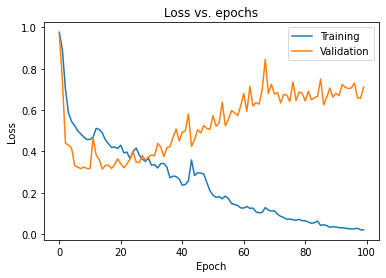

In [ ]:
# Plot the training and validation loss

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_2"></a>
## Model regularisation

#### Adding regularisation with weight decay and dropout

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras import regularizers

In [ ]:
def get_regularised_model(wd, rate):
    model = Sequential([
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu", input_shape=(train_data.shape[1],)),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(128, kernel_regularizer=regularizers.l2(wd), activation="relu"),
        Dropout(rate),
        Dense(1)
    ])
    return model

In [ ]:
# Re-build the model with weight decay and dropout layers
model = get_regularised_model(1e-5, 0.3)


In [ ]:
# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Train the model, with some of the data reserved for validation
history = model.fit(train_data, train_targets, epochs=100,
                    validation_split=0.15, batch_size=64, verbose=False)


In [ ]:
# Evaluate the model on the test set
model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.5476 - mae: 0.6160


[0.5476164221763611, 0.6159626245498657]

#### Plot the learning curves

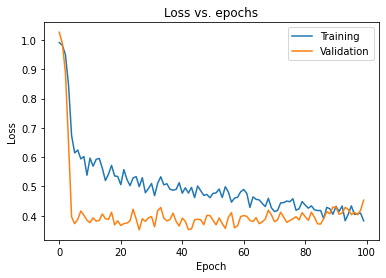

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

***
<a id="coding_tutorial_3"></a>
## Introduction to callbacks

#### Example training callback

In [ ]:
# Write a custom callback

from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
  def on_train_begin(self, logs=None):
    print('Starting training....')
  def on_epoch_begin(self, epoch, logs=None):
    print(f'Starting epoch {epoch}')
  def on_train_batch_begin (self, batch, logs=None):
    print(f'Training: Starting batch {batch}')
  def on_train_batch_end (self, batch, logs=None):
    print(f'Training: Finished batch {batch}')
  def on_epoch_end(self, epoch, logs=None):
    print(f'Finished epoch {epoch}')
  def on_train_end(self, logs=None):
    print('Finished training!')

class TestingCallback(Callback):
  def on_test_begin(self, logs=None):
    print('Starting testing....')
  def on_test_batch_begin (self, batch, logs=None):
    print(f'Testing: Starting batch {batch}')
  def on_test_batch_end (self, batch, logs=None):
    print(f'Testing: Finished batch {batch}')
  def on_test_end(self, logs=None):
    print('Finished testing!')

class PredictionCallback(Callback):
  def on_predict_begin(self, logs=None):
    print('Starting prediction....')
  def on_predict_batch_begin (self, batch, logs=None):
    print(f'Prediction: Starting batch {batch}')
  def on_predict_batch_end (self, batch, logs=None):
    print(f'Prediction: Finished batch {batch}')
  def on_predict_end(self, logs=None):
    print('Finished prediction!')

In [ ]:
# Re-build the model

model = get_regularised_model(1e-5, 0.3)

In [ ]:
# Compile the model

model.compile(optimizer='adam', loss='mse')

#### Train the model with the callback

In [ ]:
# Train the model, with some of the data reserved for validation

model.fit(train_data, train_targets, epochs=3, batch_size=128, verbose=False, callbacks=[TrainingCallback()])

Starting training....
Starting epoch 0
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 0
Starting epoch 1
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 1
Starting epoch 2
Training: Starting batch 0
Training: Finished batch 0
Training: Starting batch 1
Training: Finished batch 1
Training: Starting batch 2
Training: Finished batch 2
Training: Starting batch 3
Training: Finished batch 3
Finished epoch 2
Finished training!


In [ ]:
# Evaluate the model

model.evaluate(test_data, test_targets, verbose=False, callbacks=[TestingCallback()])

Starting testing....
Testing: Starting batch 0
Testing: Finished batch 0
Testing: Starting batch 1
Testing: Finished batch 1
Finished testing!


0.9886614680290222

In [ ]:
# Make predictions with the model

model.predict(test_data, verbose=False, callbacks=[PredictionCallback()])

Starting prediction....
Prediction: Starting batch 0
Prediction: Finished batch 0
Prediction: Starting batch 1
Prediction: Finished batch 1
Finished prediction!


array([[-0.0738861 ],
       [-0.11965873],
       [-0.09162753],
       [-0.08533353],
       [-0.08783415],
       [ 0.02809876],
       [-0.06070697],
       [-0.10686506],
       [-0.10756768],
       [ 0.00167381],
       [-0.09041429],
       [ 0.00241039],
       [-0.11200672],
       [ 0.01500776],
       [-0.09758618],
       [-0.08792196],
       [-0.03834811],
       [-0.10878371],
       [-0.05601936],
       [ 0.02120996],
       [-0.10419875],
       [ 0.00624452],
       [-0.07024971],
       [-0.08856403],
       [ 0.00426054],
       [ 0.01933733],
       [-0.09484108],
       [ 0.0096888 ],
       [-0.0632652 ],
       [-0.1146524 ],
       [-0.11536421],
       [-0.1172011 ],
       [-0.02842563],
       [-0.03902924],
       [-0.04300314],
       [-0.09400433],
       [-0.1037849 ],
       [ 0.01153408],
       [-0.04740708],
       [ 0.01497832],
       [-0.09983509],
       [-0.12020766],
       [-0.05697314],
       [-0.05839368],
       [-0.02460409]], dtype=flo

***
<a id="coding_tutorial_4"></a>
## Early stopping / patience

#### Re-train the models with early stopping

In [ ]:
# Re-train the unregularised model
unregularised_model = get_model()
unregularised_model.compile(optimizer='adam', loss='mse')
unreg_history = unregularised_model.fit(train_data, train_targets, epochs=100,
                                        validation_split=0.15, batch_size=64, verbose=False,
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])


In [ ]:
# Evaluate the model on the test set
unregularised_model.evaluate(test_data, test_targets, verbose=2)


2/2 - 0s - loss: 0.5304


0.5304205417633057

In [ ]:
# Re-train the regularised model
regularised_model = get_regularised_model(1e-8, 0.2)
regularised_model.compile(optimizer='adam',loss='mse')
reg_history = regularised_model.fit(train_data, train_targets, epochs=100,
                                        validation_split=0.15, batch_size=64, verbose=False,
                                        callbacks=[tf.keras.callbacks.EarlyStopping(patience=5)])


In [ ]:
# Evaluate the model on the test set

regularised_model.evaluate(test_data, test_targets, verbose=3)

0.585628867149353

#### Plot the learning curves

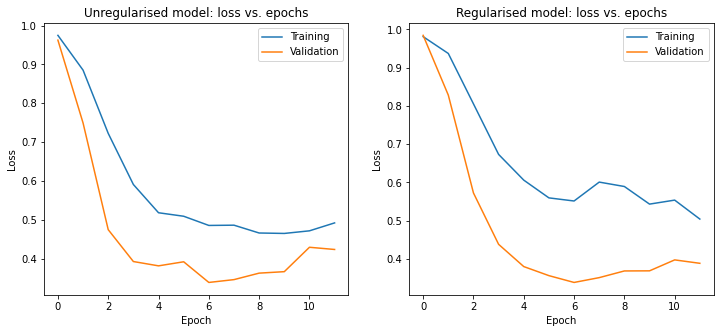

In [ ]:
# Plot the training and validation loss

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(unreg_history.history['loss'])
plt.plot(unreg_history.history['val_loss'])
plt.title('Unregularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)

plt.plot(reg_history.history['loss'])
plt.plot(reg_history.history['val_loss'])
plt.title('Regularised model: loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

plt.show()